# GENERAR DATALOADERS A PARTIR DE DATOS PROPIOS EN PYTORCH

Ahora generaremos una clase `dataset` a partir de nuestra propia base de datos, esto con el fin de facilitar la preparación de los datos que es una de las tareas más engorrosas en cualquier proyecto de aprendizaje de máquinas. Asimismo, trataremos de simplificar el preprocesamiento/aumento de datos en este dataset.

### Crear la clase `dataset`

Para que la clase dataset quede bien definida debe contener como mínimo lo métodos `__init__`, `__len__` y `__get_item__` que definiremos a continuación.

In [1]:
import torch
import nibabel as nib
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

#### Método `__init__`

El primer paso es crear el método `__init__` el cual se llama cuando se crea el daataset y contiene una variable que almacena la ruta en la cual se encuentran los datos.

#### Método `__len__`

El segundo paso es crear el método `__len__` que retorna el número de datos o tamaño del dataset.

#### Método `__get_item__`

El método `__get_item__` permite iterar a través de los elementos del dataset, es decir, permite tomar muestras de elementos en el dataset.

In [10]:
class UNET_Dataset(Dataset):

	def __init__(self, path_file):

		self.path = path_file
	def __len__(self):

		train_ids = next(os.walk(self.path))[1]
		self.dims = np.zeros(len(train_ids))

		for i in range(len(train_ids)):
			img_path = os.path.join(self.path, train_ids[i])
			image = nib.load(os.path.join(img_path, 'T1.nii'))
			image_data = image.get_fdata()
			self.dims[i] = image_data.shape[2]

		return int(np.sum(self.dims))
    
	def __getitem__(self, idx):

		c_sum = np.cumsum(self.dims)

		f = c_sum < idx
		ind_f = int(np.where(f==False)[0][0])

		if ind_f > 0:
			ind_img = int(idx % c_sum[ind_f-1] - 1)
		else:
			ind_img = int(idx - 1)

		train_ids = next(os.walk(self.path))[1]
		img_path = os.path.join(self.path, train_ids[ind_f])

		image = nib.load(os.path.join(img_path, 'T1.nii'))
		image_data = image.get_fdata()

		mask = nib.load(os.path.join(img_path, 'LabelsForTraining.nii')) 
		mask_data = mask.get_fdata()

		return (torch.from_numpy(image_data[:,:,ind_img]), torch.from_numpy(mask_data[:,:,ind_img]))

In [12]:
DATA_PATH_IMG = '/media/david/datos1/Coding/maestria/trabajo_de_grado/databases/MRBrainS13DataNii/TrainingData'

cabezas = UNET_Dataset(DATA_PATH_IMG)

cabezas_dataset = DataLoader(cabezas, batch_size=80, shuffle=True)
print(cabezas_dataset)

images, labels = next(iter(cabezas_dataset))

print(images.shape)
print(labels.shape)

torch.Size([80, 240, 240])
torch.Size([80, 240, 240])


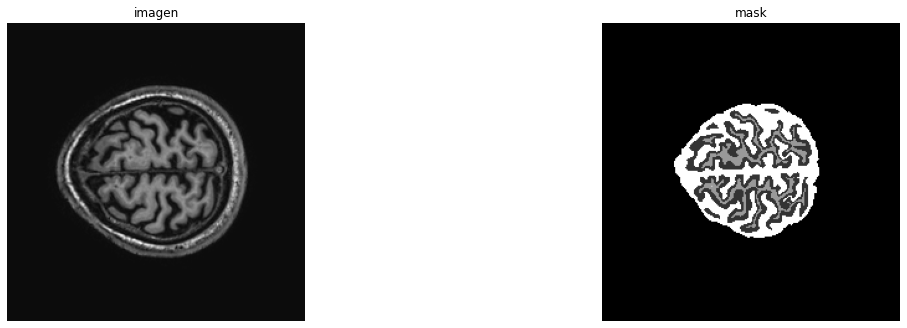

In [15]:
slice_ = images.shape[0] // 2

fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=1 ,wspace=1)

ax1 = fig.add_subplot(1,2,1)
ax1.title.set_text('imagen')
ax1.axis("off")
ax1.imshow(images[slice_,:,:],cmap="gray")

ax2 = fig.add_subplot(1,2,2)
ax2.title.set_text('mask')
ax2.axis("off")
ax2.imshow(labels[slice_, :, :],cmap="gray")

plt.show()